# Network analysis in Python

Finding a shortest path using a specific street network is a common GIS problem that has many practical
applications. For example navigators are one of those "every-day" applications where **routing** using specific algorithms is used to find the optimal route between two (or multiple) points.

It is also possible to perform network analysis such as tranposrtation routing in Python.
[Networkx](https://networkx.github.io/documentation/stable/) is a Python module that provides
a lot tools that can be used to analyze networks on various different ways. It also contains algorithms
such as [Dijkstra's algorithm](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.weighted.single_source_dijkstra.html#networkx.algorithms.shortest_paths.weighted.single_source_dijkstra) or
[A*](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.astar.astar_path.html#networkx.algorithms.shortest_paths.astar.astar_path) algoritm that are commonly used to find shortest paths along transportation network.

To be able to conduct network analysis, it is, of course, necessary to have a network that is used for the analyses. [OSMnx](https://github.com/gboeing/osmnx) package that we just explored in previous tutorial, makes it really easy to retrieve routable networks from OpenStreetMap with different transport modes (walking, cycling and driving). Osmnx also combines some functionalities from `networkx` module to make it straightforward to conduct routing along OpenStreetMap data.

Next we will test the routing functionalities of osmnx by finding a shortest path between two points based on drivable roads.

- Let's first download the OSM data from Kamppi but this time include only such street segments that are walkable. In omsnx it is possible to retrieve only such streets that are drivable by specifying `'drive'` into `network_type` parameter that can be used to specify what kind of streets are retrieved from OpenStreetMap (other possibilities are `walk` and `bike`).


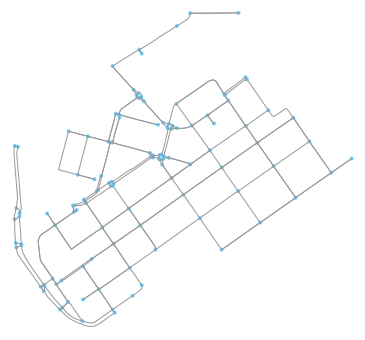

In [3]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

place_name = "Kamppi, Helsinki, Finland"
graph = ox.graph_from_place(place_name, network_type='drive')
fig, ax = ox.plot_graph(graph)

Okey so now we have retrieved only such streets where it is possible to drive with a car. Let's confirm
this by taking a look at the attributes of the street network. Easiest way to do this is to convert the
graph (nodes and edges) into GeoDataFrames.

- Converting graph into a GeoDataFrame can be done with function `graph_to_gdfs()` that we already used in previous tutorial. With parameters `nodes` and `edges`, it is possible to control whether to retrieve both nodes and edges from the graph. Here, we only retrieve edges:

In [8]:
# Retrieve only edges from the graph
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)

# Check columns
print(edges.columns)

# Check crs
print(edges.crs)

Index(['access', 'bridge', 'geometry', 'highway', 'junction', 'key', 'lanes',
       'length', 'maxspeed', 'name', 'oneway', 'osmid', 'u', 'v'],
      dtype='object')
{'init': 'epsg:4326'}


Okey, so we have quite many columns in our GeoDataFrame. Most of the columns are fairly self-explanatory but the following table describes all of them. We can also see that the CRS of the GeoDataFrame seems to be WGS84 (i.e. epsg: 4326).


| Column                                                     | Description                 | Data type         |
|------------------------------------------------------------|-----------------------------|-------------------|
| [bridge](http://wiki.openstreetmap.org/wiki/Key:bridge)    | Bridge feature              | boolean           |
| geometry                                                   | Geometry of the feature     | Shapely.geometry  |
| [highway](http://wiki.openstreetmap.org/wiki/Key:highway)  | Tag for roads (road type)   | str / list        |
| [lanes](http://wiki.openstreetmap.org/wiki/Key:lanes)      | Number of lanes             | int (or nan)      |
| [lenght](http://wiki.openstreetmap.org/wiki/Key:length)    | Length of feature (meters)  | float             |
| [maxspeed](http://wiki.openstreetmap.org/wiki/Key:maxspeed)| maximum legal speed limit   | int /list         |
| [name](http://wiki.openstreetmap.org/wiki/Key:name)        | Name of the (street) element| str (or nan)      |
| [oneway](http://wiki.openstreetmap.org/wiki/Key:oneway)    | One way road                | boolean           |
| [osmid](http://wiki.openstreetmap.org/wiki/Node)           | Unique ids for the element  | list              |
| [u](http://ow.ly/bV8n30h7Ufm)                              | The first node of edge      | int               |
| [v](http://ow.ly/bV8n30h7Ufm)                              | The last node of edge       | int               |


Most of the attributes above comes directly from the OpenStreetMap, however, columns `u` and `v` are Networkx specific ids.

- Let's take a look what kind of features we have in the `highway` column:

In [7]:
print(edges['highway'].value_counts())

residential      112
tertiary          78
primary           26
secondary         17
unclassified      11
living_street      4
primary_link       1
Name: highway, dtype: int64

Okey, now we can confirm that as a result our street network indeed only contains such streets where it is allowed to drive with a car as there are no e.g. cycleways or footways included in the data.

- Let's continue and find the shortest path between two points based on the distance. As the data is in WGS84 format, we might first want to reproject our data into metric system so that our map looks better.
Luckily there is a handy function in OSMnx called `project_graph()` to project the graph data in UTM format.


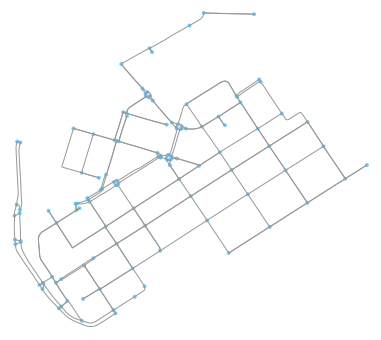

In [9]:
graph_proj = ox.project_graph(graph)
fig, ax = ox.plot_graph(graph_proj)    

We can see a modest change in the appearance of the graph. But let's take a closer look by seeing how the data values look now:

In [11]:
# Get Edges and Nodes
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)
print("Coordinate system:", edges_proj.crs)
print(edges_proj.head())

Coordinate system: {'zone': 35, 'units': 'm', 'proj': 'utm', 'ellps': 'WGS84', 'datum': 'WGS84'}
  access bridge                                           geometry  \
0    NaN    NaN  LINESTRING (385359.3161680779 6671864.64583349...   
1    NaN    NaN  LINESTRING (385078.4206660209 6671287.11004645...   
2    NaN    NaN  LINESTRING (385154.9188669115 6671743.59020305...   
3    NaN    NaN  LINESTRING (385122.9978634067 6671765.36403810...   
4    NaN    NaN  LINESTRING (385122.9978634067 6671765.36403810...   

        highway    junction  key lanes   length maxspeed             name  \
0   residential         NaN    0   NaN   38.739       30   Kansakoulukuja   
1  primary_link         NaN    0     2   55.594       40              NaN   
2      tertiary  roundabout    0     1    3.875       30              NaN   
3   residential         NaN    0   NaN  140.354       30  Lapinlahdenkatu   
4   residential         NaN    0   NaN   13.671       40              NaN   

   oneway          

Okey, as we can see from the CRS the data is now in [UTM projection](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system) using zone 35 which is the one used for Finland, and indeed the orientation of the map and the geometry values also confirm this.


## Analyzing the network properties

Now as we have seen some of the basic functionalities of osmnx such as downloading the data and converting data from graph to GeoDataFrame, we can take a look some of the analytical features of omsnx. Osmnx includes many useful functionalities to extract information about the network.

- To calculate some of the basic street network measures we can use `basic_stats()` function in OSMnx:

In [12]:
# Calculate network statistics
stats = ox.basic_stats(graph_proj)
stats

{'circuity_avg': 1.2711348550352305e-05,
 'clean_intersection_count': None,
 'clean_intersection_density_km': None,
 'edge_density_km': None,
 'edge_length_avg': 80.16320481927708,
 'edge_length_total': 19960.637999999995,
 'intersection_count': 116,
 'intersection_density_km': None,
 'k_avg': 4.016129032258065,
 'm': 249,
 'n': 124,
 'node_density_km': None,
 'self_loop_proportion': 0.0,
 'street_density_km': None,
 'street_length_avg': 74.59165573770494,
 'street_length_total': 13650.273000000003,
 'street_segments_count': 183,
 'streets_per_node_avg': 3.217741935483871,
 'streets_per_node_counts': {0: 0, 1: 8, 2: 1, 3: 71, 4: 44},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.06451612903225806,
  2: 0.008064516129032258,
  3: 0.5725806451612904,
  4: 0.3548387096774194}}

To be able to extract the more advanced statistics (and some of the missing ones above) from the street network, it is required to have information about the coverage area of the network. Let's calculate the area of the [convex hull](https://en.wikipedia.org/wiki/Convex_hull) of the street network and see what we can get.
As certain statistics are produced separately for each node, they produce a lot of output. Let's merge both stats and put them into Pandas Series to keep things in more compact form.


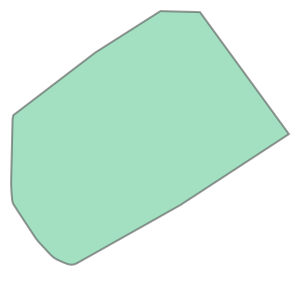

In [14]:
# Get the Convex Hull of the network
convex_hull = edges_proj.unary_union.convex_hull
# Show output
convex_hull

Now we can use the Convex Hull above to calculate e.g. denisity statistics:

In [15]:
# Calculate the area
area = convex_hull.area

# Calculate statistics with density information
stats = ox.basic_stats(graph_proj, area=area)
extended_stats = ox.extended_stats(graph_proj, ecc=True, bc=True, cc=True)
for key, value in extended_stats.items():
    stats[key] = value
pd.Series(stats)

avg_neighbor_degree                    {3216400385: 3.0, 1372233731: 1.0, 267117317: ...
avg_neighbor_degree_avg                                                          2.14315
avg_weighted_neighbor_degree           {3216400385: 0.07744133818632387, 1372233731: ...
avg_weighted_neighbor_degree_avg                                               0.0784928
betweenness_centrality                 {3216400385: 0.0, 1372233731: 0.00766360122617...
betweenness_centrality_avg                                                     0.0670253
center                                                                      [1372376937]
circuity_avg                                                                 1.27113e-05
clean_intersection_count                                                            None
clean_intersection_density_km                                                       None
closeness_centrality                   {3216400385: 0.0014752477711614846, 1372233731...
closeness_centrality_

As we can see, now we have a **LOT** of information about our street network that can be used to understand its structure. We can for example see that the average node density in our network is `149 nodes/km` and that the total edge length of our network is `19960.6 meters`.

Furthermore, we can see that the [degree centrality](https://en.wikipedia.org/wiki/Centrality) of our network is on average `0.0326515`. Degree is a simple centrality measure that counts how many neighbors a node has (here a fraction of nodes it is connected to). Another interesting measure is the [PageRank](https://en.wikipedia.org/wiki/PageRank) that measures the importance of specific node in the graph. Here we can see that the most important node in our graph seem to a node with osmid `25416262`. PageRank was the algorithm that Google first developed (Larry Page & Sergei Brin) to order the search engine results and became famous for.

You can read the [Wikipedia article about different centrality measures](https://en.wikipedia.org/wiki/Centrality) if you are interested what the other centrality measures mean.

## Shortest path analysis

Let's now calculate the shortest path between two points. First we need to specify the source and target locations for our route. Let's use the centroid of our network as the source location and the furthest point in East in our network as the target location.

Let's first determine the centroid of our network. We can take advantage of the same `Convex Hull` that we used previously to determine the centroid of our data.


In [19]:
# Get the Convex Hull of the network
convex_hull = edges_proj.unary_union.convex_hull

# Centroid
centroid = convex_hull.centroid

# Show
print(centroid)

POINT (385170.115258674 6671717.254450418)


As we can see, now we have a centroid of our network determined. We will use this later as an origin point in our routing operation. 

- Let's now find the easternmost node in our street network. We can do this by calculating the x coordinates and finding out which node has the largest x-coordinate value. Let's ensure that the values are floats.

In [20]:
# Get the x coordinates of the nodes
nodes_proj['x'] = nodes_proj.x.astype(float)

# Retrieve the maximum x value (i.e. the most eastern)
maxx = nodes_proj['x'].max()
print(maxx)

385855.0300992895


- Let's retrieve the target Point having the largest x-coordinate. We can do this by using the `.loc` function of Pandas that we have used already many times in earlier tutorials.

In [26]:
# Retrieve the node that is the most eastern one and get the Shapely Point geometry out of it
target = nodes_proj.loc[nodes_proj['x']==maxx, 'geometry'].values[0]
print(target)

POINT (385855.0300992895 6671721.810323974)


Okey now we can see that as a result we have a Shapely Point that we can use as a target point in our routing.

- Let's now find the nearest graph nodes (and their node-ids) to these points. For OSMnx we need to parse the coordinates of the Point as coordinate-tuple with Latitude, Longitude coordinates. As our data is now projected to UTM projection, we need to specify with `method` parameter that the function uses `'euclidean'` distances to calculate the distance from the point to the closest node. This becomes important if you want to know the actual distance between the Point and the closest node which you can retrieve by specifying parameter `return_dist=True`.


In [27]:
# Get origin x and y coordinates
orig_xy = (centroid.y, centroid.x)

# Get target x and y coordinates
target_xy = (target.y, target.x)

# Find the closest origin and target nodes from the graph (the ids of them)
orig_node = ox.get_nearest_node(graph_proj, orig_xy, method='euclidean')
target_node = ox.get_nearest_node(graph_proj, target_xy, method='euclidean')

# Show the results
print(orig_node)
print(target_node)

301360197
317703609


Now we have the IDs for the closest nodes that were found from the graph to the origin and target points that we specified. 

- Let's retrieve the node information from the `nodes_proj` GeoDataFrame by passing the ids to the `loc` indexer, and make a GeoDataFrame out of them:

In [31]:
# Retrieve the rows from the nodes GeoDataFrame
o_closest = nodes_proj.loc[orig_node]
t_closest = nodes_proj.loc[target_node]

# Create a GeoDataFrame from the origin and target points
od_nodes = gpd.GeoDataFrame([o_closest, t_closest], geometry='geometry', crs=nodes_proj.crs)

od_nodes.head()

highway        lat        lon      osmid              x  \
301360197              NaN  60.166212  24.930617  301360197  385166.707932   
317703609  traffic_signals  60.166410  24.943012  317703609  385855.030099   

                      y                                     geometry  
301360197  6.671721e+06  POINT (385166.7079315781 6671721.244047897)  
317703609  6.671722e+06  POINT (385855.0300992895 6671721.810323974)

Okay, as a result we got now the closest node-ids of our origin and target locations. As you can see, the `index` in this GeoDataFrame corresponds to the IDs that we found with `get_nearest_node()` function.

- Now we are ready to do the routing and find the shortest path between the origin and target locations
by using the `shortest_path()` [function](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.generic.shortest_path.html) of networkx.
With `weight` -parameter we can specify that `'length'` attribute should be used as the cost impedance in the routing. If specifying the weight parameter, NetworkX will use by default Dijkstra's algorithm to find the optimal route. We need to specify the graph that is used for routing, and the origin `ID` (*source*) and the target `ID` in between the shortest path will be calculated:


In [33]:
# Calculate the shortest path
route = nx.shortest_path(G=graph_proj, source=orig_node, target=target_node, weight='length')

# Show what we have
print(route)

[301360197, 1372441183, 1372441170, 60170471, 1377211668, 1377211666, 25291565, 25291564, 317703609]


As a result we get a list of all the nodes that are along the shortest path. 

- We could extract the locations of those nodes from the `nodes_proj` GeoDataFrame and create a LineString presentation of the points, but luckily, OSMnx can do that for us and we can plot shortest path by using `plot_graph_route()` function:


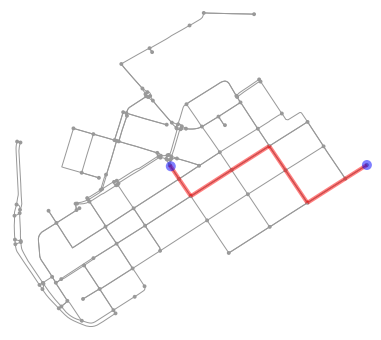

In [34]:
# Plot the shortest path
fig, ax = ox.plot_graph_route(graph_proj, route, origin_point=orig_xy, destination_point=target_xy)

Nice! Now we have the shortest path between our origin and target locations.
Being able to analyze shortest paths between locations can be valuable information for many applications.
Here, we only analyzed the shortest paths based on distance but quite often it is more useful to find the
optimal routes between locations based on the travelled time. Here, for example we could calculate the time that it takes to cross each road segment by dividing the length of the road segment with the speed limit and calculate the optimal routes by taking into account the speed limits as well that might alter the result especially on longer trips than here.

## Saving shortest paths to disk

Quite often you need to save the route e.g. as a Shapefile.
Hence, let's continue still a bit and see how we can make a Shapefile of our route with some information associated with it.

- First we need to get the nodes that belong to the shortest path:


In [35]:
# Get the nodes along the shortest path
route_nodes = nodes_proj.loc[route]
print(route_nodes)

                    highway      lat      lon       osmid              x  \
301360197               NaN  60.1662  24.9306   301360197  385166.707932   
1372441183              NaN  60.1658  24.9312  1372441183  385199.040423   
1372441170              NaN  60.1652   24.932  1372441170  385239.956998   
60170471                NaN  60.1661  24.9345    60170471  385382.590391   
1377211668              NaN  60.1669  24.9368  1377211668  385514.080702   
1377211666              NaN  60.1662  24.9379  1377211666  385570.886277   
25291565    traffic_signals  60.1651  24.9393    25291565  385647.135653   
25291564                NaN  60.1659  24.9417    25291564  385779.465694   
317703609   traffic_signals  60.1664   24.943   317703609  385855.030099   

                      y                                     geometry  
301360197   6.67172e+06  POINT (385166.7079315781 6671721.244047897)  
1372441183  6.67167e+06  POINT (385199.0404225526 6671671.819812791)  
1372441170  6.67161e+06  P

As we can see, now we have all the nodes that were part of the shortest path as a GeoDataFrame.

- Now we can create a LineString out of the Point geometries of the nodes:

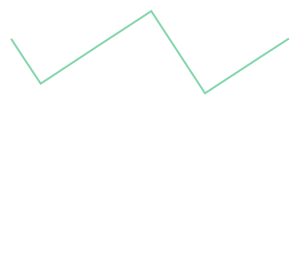

In [37]:
from shapely.geometry import LineString, Point

# Create a geometry for the shortest path
route_line = LineString(list(route_nodes.geometry.values))
route_line

Now we have the route as a LineString geometry. 

- Let's make a GeoDataFrame out of it having some useful information about our route such as a list of the osmids that are part of the route and the length of the route.

In [39]:
# Create a GeoDataFrame
route_geom = gpd.GeoDataFrame([[route_line]], geometry='geometry', crs=edges_proj.crs, columns=['geometry'])

# Add a list of osmids associated with the route
route_geom.loc[0, 'osmids'] = str(list(route_nodes['osmid'].values))

# Calculate the route length
route_geom['length_m'] = route_geom.length

route_geom.head()

geometry  \
0  LINESTRING (385166.7079315781 6671721.24404789...   

                                              osmids    length_m  
0  ['301360197', '1372441183', '1372441170', '601...  952.294307

Now we have a GeoDataFrame that we can save to disk. Let's still confirm that everything is okey by plotting our route on top of our street network and some buildings, and plot also the origin and target points on top of our map.

- Get buildings:

In [40]:
# Retrieve buildings and reproject
buildings = ox.buildings_from_place(place_name)
buildings_proj = buildings.to_crs(crs=edges_proj.crs)

- Let's now plot the route and the street network elements to verify that everything is as it should:

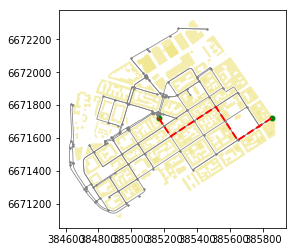

In [44]:
# Plot edges and nodes
ax = edges_proj.plot(linewidth=0.75, color='gray')
ax = nodes_proj.plot(ax=ax, markersize=2, color='gray')

# Add buildings
ax = buildings_proj.plot(ax=ax, facecolor='khaki', alpha=0.7)

# Add the route
ax = route_geom.plot(ax=ax, linewidth=2, linestyle='--', color='red')

# Add the origin and destination nodes of the route
ax = od_nodes.plot(ax=ax, markersize=24, color='green')

Great everything seems to be in order! As you can see, now we have a full control of all the elements of our map and we can use all the aesthetic properties that matplotlib provides to modify how our map will look like. Now we are almost ready to save our data into disk.


- As there are certain columns with such data values that Shapefile format does not support (such as `list` or `boolean`), we need to convert those into strings to be able to export the data to Shapefile:

In [47]:
# Columns with invalid values
invalid_cols = ['lanes', 'maxspeed', 'name', 'oneway', 'osmid']

# Iterate over invalid columns and convert them to string format
for col in invalid_cols:
    edges_proj[col] = edges_proj[col].astype(str)
    
print(edges_proj.dtypes)

access       object
bridge       object
geometry     object
highway      object
junction     object
key           int64
lanes        object
length      float64
maxspeed     object
name         object
oneway       object
osmid        object
u             int64
v             int64
dtype: object


Now we can see that most of the attributes are of type `object` that quite often (such as ours here) refers to a string type of data.

- Now we are finally ready to parse the output filepaths and save the data into disk:

In [49]:
import os

# Parse the place name for the output file names (replace spaces with underscores and remove commas)
place_name_out = place_name.replace(' ', '_').replace(',','')

# Output directory
out_dir = "data"

# Parse output file paths
streets_out = os.path.join(out_dir, "%s_streets.shp" % place_name_out)
route_out = os.path.join(out_dir, "Route_from_a_to_b_at_%s.shp" % place_name_out)
nodes_out = os.path.join(out_dir, "%s_nodes.shp" % place_name_out)
buildings_out = os.path.join(out_dir, "%s_buildings.shp" % place_name_out)
od_out = os.path.join(out_dir, "%s_route_OD_points.shp" % place_name_out)

# Save files
edges_proj.to_file(streets_out)
route_geom.to_file(route_out)
nodes_proj.to_file(nodes_out)
od_nodes.to_file(od_out)
buildings[['geometry', 'name', 'addr:street']].to_file(buildings_out)

Great, now we have saved all the data that was used to produce the maps as Shapefiles.